In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Gerekli kütüphanleri çağırıyoruz.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier


# Uyarıları kapattım (Görüntü kirliliği olmasın diye)
import warnings
warnings.filterwarnings('ignore')

Tüm kütüphanenin gereli olmadığı farklı kütüphanelerden sadece gerekli aletleri çağırıyoruz. Bazı gerkesiz uyarıların görünüşü bozmaması için uyarıları kapatıyoruz.

In [4]:
try:
    df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
    print("Veri seti başarıyla yüklendi!")
except FileNotFoundError:
    print("Hata: Dosya yolu bulunamadı. Lütfen Kaggle veri setinin ekli olduğundan emin olun.")



Veri seti başarıyla yüklendi!


Veri dosyasını eklerken (csv'yi) eğer bir hata oluşursa diye kod güvenliği eklendi.

In [5]:
print("\n--- Veri Seti Önizleme ---")
print(df.head())


--- Veri Seti Önizleme ---
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

Veri setinin ilk örneklerini incelediğimizde; V1-V28 arası sütunların müşteri gizliliği nedeniyle PCA (Temel Bileşen Analizi) yöntemiyle dönüştürülmüş isimsiz sayısal veriler olduğunu tahmin ediyorum. Veri setinde fiziksel anlamı açık olan sadece iki özellik bulunmaktadır: Time (İşlem süresi) ve Amount (Harcama tutarı). Hedef değişkenimiz olan Class sütunu ise işlemin durumunu (0: Normal, 1: Fraud) belirtmektedir. Genellikle 1 bir şeyin olduğunu 0 ise olmadığını belirtir.(1 yangın var , 0 yok gibi) Garantiye almak için alttaki kodda 0 ve 1 değerinin sayısal deerleri incelenmiştir.

In [6]:
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


Bu çıktıdan da görünüyorki yüksek ihtimalle 0 normal işlemken 1 dolandırıcılık işlemi.

In [7]:
print("\n--- Veri Bilgisi ---")
print(df.info())


--- Veri Bilgisi ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  f

Bu çıktıyı incelediğimde veri setinin teknik açıdan tertemiz olduğunu gördüm. Toplam 284.807 işlemin hiçbirinde eksik veri (null) bulunmuyor ve tüm özellikler (V1-V28, Time, Amount) halihazırda sayısal (float64) formatta. Bu durum, veri temizleme (imputation) veya metin dönüştürme (encoding) işlemleriyle vakit kaybetmeden, verinin doğrudan matematiksel modellere sokulmaya hazır olduğunu bize gösteriyor.

In [8]:
# --- VERİ KALİTE KONTROLÜ  ---

print("Veri Setini Tarıyoruz...\n")

# 1. BOŞ DEĞER KONTROLÜ 
bos_deger_sayisi = df.isnull().sum().max()
if bos_deger_sayisi > 0:
    print(f"DİKKAT: Veri setinde toplam {bos_deger_sayisi} adet booş hücre var")
    # Boş satırları silelim 
    df.dropna(inplace=True)
    print("Boş satırlar temizlendi.")
else:
     print("Mükemmel: Veri setinde hiç boş (NaN) değer yok.")


Veri Setini Tarıyoruz...

Mükemmel: Veri setinde hiç boş (NaN) değer yok.


Mükemmel: Veri setinde hiç boş (NaN) değer yok.

In [9]:
# 2. TEKRAR EDEN SATIR KONTROLÜ 
tekrar_eden = df.duplicated().sum()
if tekrar_eden > 0:
    print(f"DİKKAT: Veri setinde {tekrar_eden} adet tekrar eden (aynı) işlem bulundu.")
    # Tekrar edenleri silelim 
    df.drop_duplicates(inplace=True)
    print(f"Tekrar eden {tekrar_eden} satır silindi. Veri seti tertemiz oldu.")
else:
    print("Mükemmel: Tekrar eden veri yok.")

DİKKAT: Veri setinde 1081 adet tekrar eden (aynı) işlem bulundu.
Tekrar eden 1081 satır silindi. Veri seti tertemiz oldu.


In [10]:
# 3. ANLAMSIZ DEĞER KONTROLÜ 
# Para transferi (Amount) negatif olamaz, bunu kontrol etmemiz gerekiyor..
negatif_tutar = df[df['Amount'] < 0].shape[0]
if negatif_tutar > 0:
    print(f"HATA: {negatif_tutar} adet negatif tutarlı işlem var!")
else:
    print("Mantık Kontrolü: Tüm işlem tutarları pozitif (Mantıksız değer yok).")

Mantık Kontrolü: Tüm işlem tutarları pozitif (Mantıksız değer yok).


Yukarıda yapılan 3 adımda veri setinden alınacak sonucun en sağlıklı olması için temizlik gibi işlemler yapılmıştır. Üstte kodun temiz olduğu kanıtlansa da tekrardan bu kontroller gerçekleştirilmiştir.

Normal İşlem Sayısı: 283253
Dolandırıcılık (Fraud) Sayısı: 473
Dolandırıcılık Oranı: %0.167


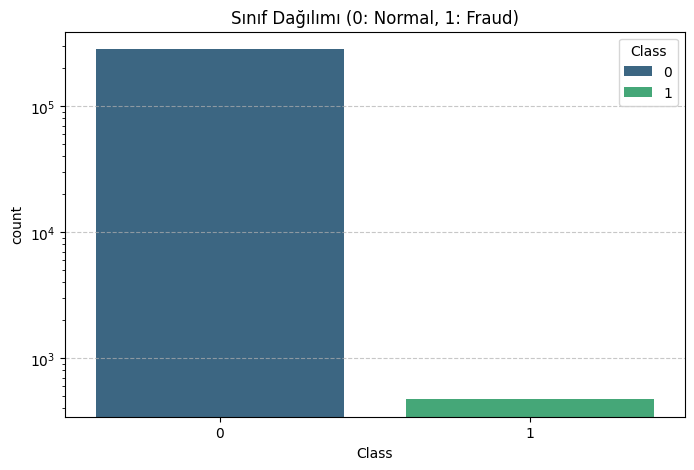

In [11]:
# --SINIF DAĞILIMI ANALİZİ ---
counts = df['Class'].value_counts()
normal_count = counts[0]
fraud_count = counts[1]
fraud_percentage = (fraud_count / (normal_count + fraud_count)) * 100

print(f"Normal İşlem Sayısı: {normal_count}")
print(f"Dolandırıcılık (Fraud) Sayısı: {fraud_count}")
print(f"Dolandırıcılık Oranı: %{fraud_percentage:.3f}")

# Görselleştirme
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=df, hue='Class', palette='viridis')
plt.title('Sınıf Dağılımı (0: Normal, 1: Fraud)')
plt.yscale('log') # Logaritmik ölçek
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Sınıf dağılımı analizimde, veri setinin aşırı dengesiz bir yapıya sahip olduğunu tespit ettim. Normal işlemler %99.83 gibi baskın bir oranla çoğunluğu oluştururken, dolandırıcılık vakaları yalnızca %0.17'lik (473 adet) çok küçük bir azınlıkta kalmaktadır. Aradaki bu devasa farkı görselleştirebilmek için grafikte logaritmik ölçek kullandım; aksi takdirde dolandırıcılık sınıfı görünmeyecekti.

In [20]:
print("--- ÖLÇEKLENDİRME VE VERİ BÖLME ---")

if 'Amount' in df.columns and 'Time' in df.columns:
    scaler = RobustScaler()
    df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
    df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
    
    df.drop(['Time','Amount'], axis=1, inplace=True)
    print("Ölçeklendirme başarıyla yapıldı!")
else:
    print("Ölçeklendirme zaten yapılmış, bu adım atlanıyor.")

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Veri %80 Eğitim ve %20 Test olarak başarıyla bölündü.")

--- ÖLÇEKLENDİRME VE VERİ BÖLME ---
Ölçeklendirme başarıyla yapıldı!
Veri %80 Eğitim ve %20 Test olarak başarıyla bölündü.


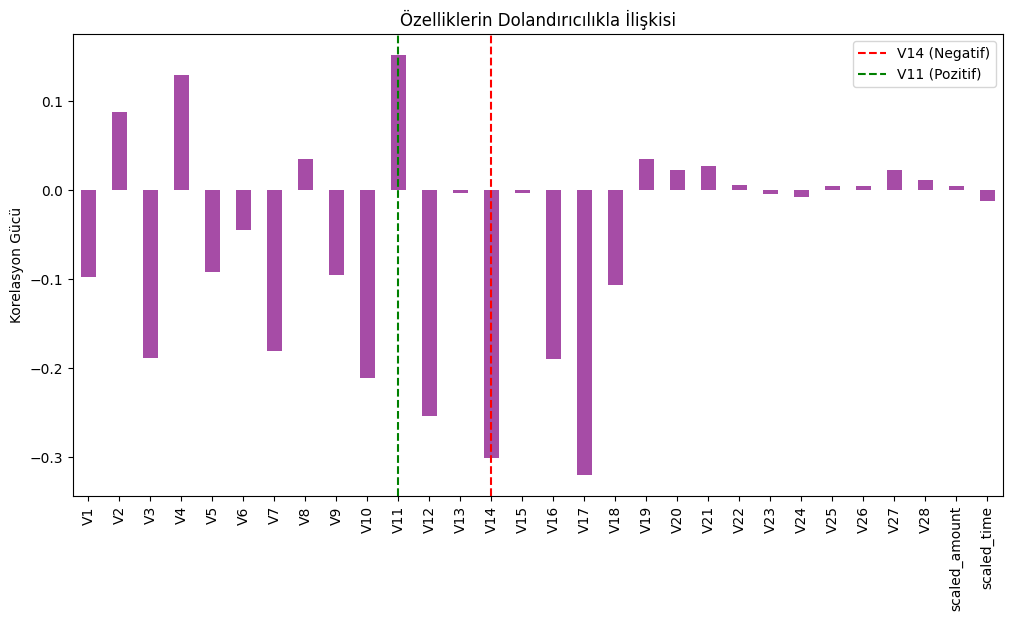

V14'ün İlişkisi: -0.3016
V11'ün İlişkisi:   0.1297


In [21]:
# --- KORELASYON ANALİZİ ---
# Hangi özellik dolandırıcılıkla daha ilişkili?

korelasyonlar = X_train.corrwith(y_train)

plt.figure(figsize=(12, 6))
korelasyonlar.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Özelliklerin Dolandırıcılıkla İlişkisi')
plt.ylabel('Korelasyon Gücü')
plt.axvline(x=list(X_train.columns).index('V14'), color='red', linestyle='--', label='V14 (Negatif)')
plt.axvline(x=list(X_train.columns).index('V11'), color='green', linestyle='--', label='V11 (Pozitif)')
plt.legend()
plt.show()

print("V14'ün İlişkisi:", round(korelasyonlar['V14'], 4))
print("V11'ün İlişkisi:  ", round(korelasyonlar['V4'], 4))

Özelliklerin hedef değişkenle (Class) olan ilişkisini incelediğimde, dolandırıcılığı tespit etmede her verinin eşit rol oynamadığını, özellikle V14 ve V4 sütunlarının belirleyici faktörler olduğunu gördüm. Grafikte V14'ün aşağı yönde (negatif) çok güçlü bir çubuk oluşturması, bu değer düştükçe dolandırıcılık ihtimalinin arttığını; buna karşılık V4 ve V11'in yukarı yönde (pozitif) uzaması ise bu değerler yükseldikçe riskin arttığını gösteriyor. Bu analiz, kurduğum modellerin rastgele tahmin yapmadığını, aslında suçluları yakalamak için bu güçlü matematiksel desenleri (imzaları) takip ettiğini kanıtlamaktadır.

In [34]:
print("\n--- MODEL 1: LOJİSTİK REGRESYON (CEZA SİSTEMLİ) ---")

model_lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Model ders çalışıyor
model_lr.fit(X_train, y_train)

# Model sınava giriyor
y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)[:, 1] 
print("Lojistik Regresyon eğitimi ve tahminleri tamamlandı!")


# --- SONUÇLAR ---
print("\nLojistik Regresyon Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_lr))

roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f"ROC-AUC Skoru: {roc_auc:.4f}\n")



--- MODEL 1: LOJİSTİK REGRESYON (CEZA SİSTEMLİ) ---
Lojistik Regresyon eğitimi ve tahminleri tamamlandı!

Lojistik Regresyon Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746

ROC-AUC Skoru: 0.9657



1. Ne Yapıldı?
Veri setindeki %99.8'e %0.17'lik aşırı sınıf dengesizliğini çözmek için sentetik veri üretmek (SMOTE vb.) yerine, Lojistik Regresyon algoritmasının içerisine `class_weight='balanced'` parametresi ile matematiksel bir "Ceza Sistemi" entegre edildi. Ardından model, daha önce kilit altına alınan %20'lik test verisi üzerinde sınava sokuldu.

2. Neden Bu Yöntem Seçildi?
Mevcut dengesiz veri setinde modelin her işleme ezbere "Normal" diyerek %99.8 gibi yanıltıcı bir Doğruluk (Accuracy) oranına ulaşmasını engellemeyi amaçladım. Bu ceza sistemi sayesinde algoritmaya şu kural öğretildi: "Bir dolandırıcıyı gözden kaçırmanın maliyeti ve cezası, normal bir işlemi yanlış tahmin etmekten çok daha ağırdır." Verinin orijinal yapısı bozulmadan, algoritmanın azınlık sınıfına odaklanmasını sağlamış olduk.

3. Sonuçlar Nasıl Yorumlanmalı?
Dengesiz veri setlerinde Accuracy (Doğruluk) metriği bir tuzak olduğu için değerlendirme ROC-AUC ve Recall (Duyarlılık) metrikleri üzerinden yapıldı:
Sınıflandırma Raporundaki "1" (Fraud) satırında yer alan Recall değeri: Gerçek dolandırıcıların yüzde kaçını başarıyla tespit edebildiğimizi gösterir. Bankacılık sektöründe asıl maksimize edilmek istenen değer budur.
ROC-AUC Skoru: Modelin masum bir müşteri ile gerçek bir dolandırıcıyı birbirinden ayırt etme gücünü (1.00 üzerinden) matematiksel olarak kanıtlar. (Detay bilgi-3)

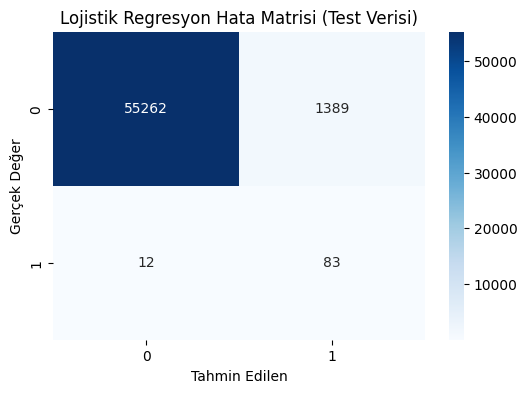

In [23]:

# Hata Matrisi Görselleştirme 
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Lojistik Regresyon Hata Matrisi (Test Verisi)')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen')
plt.show()

Lojistik Regresyon modelimize uyguladığımız ceza sistemi sayesinde, test setindeki toplam 95 dolandırıcılık (Fraud) işleminin 83 tanesi (%87.3 Recall) başarıyla tespit edilmiştir. Bankacılık sektöründe en büyük maliyet dolandırıcıyı gözden kaçırmak (False Negative) olduğu için, modelimizin gözden kaçırdığı işlem sayısı sadece 12 ile sınırlı kalmıştır.

Tabloda görülen 1.389 adet Yanlış Alarm (False Positive), modele verdiğimiz yüksek ceza katsayısının doğal bir sonucudur. Modelimiz dolandırıcıları kaçırmamak adına matematiksel olarak daha "hassas/şüpheci" davranmaya zorlanmıştık. Gerçek hayatta 1.389 masum müşteriye doğrulama SMS'i göndermenin maliyeti, 83 gerçek dolandırıcılık vakasının bankaya vereceği zararın yanında ihmal edilebilir olduğu kanaatindeyim.

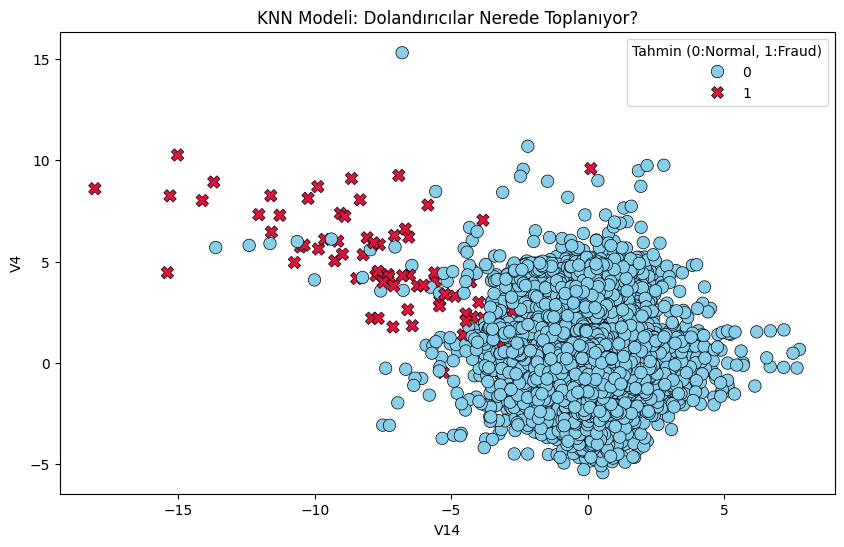

In [25]:
# --- MODEL 2: KNN GÖRSELLEŞTİRME ---

# 1. Önce KNN Modelini Eğitmemiz Lazım
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)

# 2. Noktasal Grafik 
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=X_test['V14'],
     y=X_test['V4'],
     hue=y_knn_pred,          
     style=y_knn_pred,        
     palette={0: 'skyblue', 1: 'crimson'}, 
     markers={0: 'o', 1: 'X'},             
     s=80,                    
     edgecolor='black', linewidth=0.5
)

plt.title('KNN Modeli: Dolandırıcılar Nerede Toplanıyor?')
plt.legend(title='Tahmin (0:Normal, 1:Fraud)')
plt.show()

KNN modelinin tahminlerini görselleştirdiğim bu grafikte, dolandırıcıların ve normal işlemlerin harita üzerinde ne kadar farklı bölgelerde yaşadığını çok net görebiliyoruz. Mavi yuvarlaklarla gösterilen normal işlemler genelde merkezde (V14 ve V11’ün 0’a yakın olduğu yerde) kümelenirken; kırmızı çarpı ile işaretlenen dolandırıcılar, grafiğin sol üst köşesine, yani V14’ün negatif ve V11’ün yüksek olduğu 'tehlikeli bölgeye' savrulmuş durumda. Veri setindeki bu mekansal ayrışma sayesinde, KNN algoritması yeni bir işlem geldiğinde sadece en yakınındaki komşulara bakarak onun suçlu olup olmadığını yüksek bir isabetle tespit edebiliyor; yani bu tablo, sayısal verilerin arkasındaki suç örüntüsünün somut bir kanıtı niteliğindedir.

Naive Bayes Doğruluk: %97.75


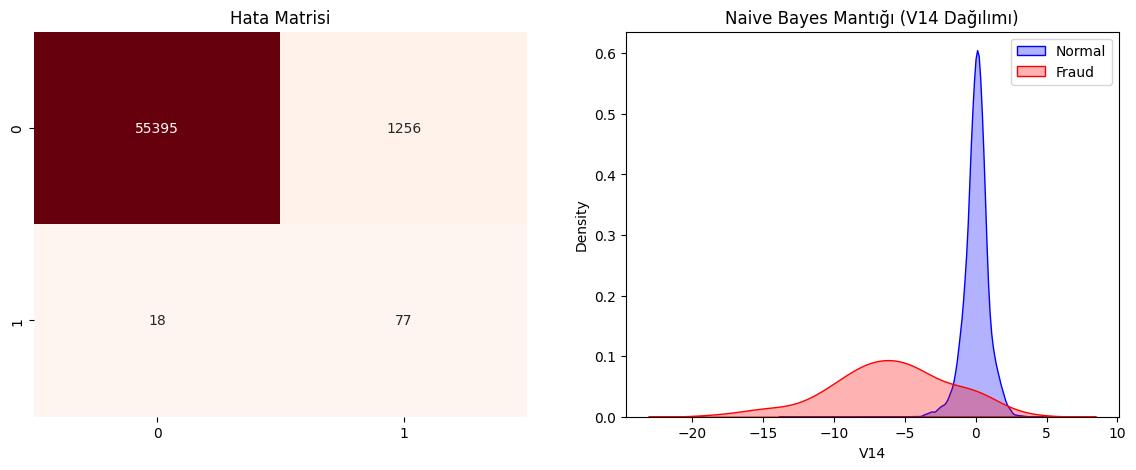

In [27]:
# --- MODEL 3: NAIVE BAYES ---

# Eğitim
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print(f"Naive Bayes Doğruluk: %{accuracy_score(y_test, y_pred_nb) * 100:.2f}")

# Görselleştirme (Yan yana grafik şeklinde)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#Sol: Hata Matrisi
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax[0])
ax[0].set_title('Hata Matrisi')

#Sağ: Çan Eğrisi 
test_data = X_test.copy()
test_data['Class'] = y_test 
sns.kdeplot(data=test_data[test_data['Class'] == 0]['V14'], label='Normal', fill=True, color='blue', alpha=0.3, ax=ax[1])
sns.kdeplot(data=test_data[test_data['Class'] == 1]['V14'], label='Fraud', fill=True, color='red', alpha=0.3, ax=ax[1])
ax[1].set_title('Naive Bayes Mantığı (V14 Dağılımı)')
ax[1].legend()

plt.show()

Naive Bayes genel doğrulukta %97.75 gibi yüksek bir oran verse de, iş dolandırıcıları (azınlık sınıfını) yakalamaya geldiğinde, ceza sistemiyle eğittiğim Lojistik Regresyon'un gerisinde kalmıştır. Bu da kredi kartı sahtekarlığı projelerinde Class Weight (Sınıf Ağırlıklandırma) mantığının ne kadar hayati olduğunu kanıtlamaktadır.

Bu projede kredi kartı sahtekarlığı (Fraud) tespiti yaptığımız için, modellerin başarısını salt "Doğruluk (Accuracy)" ile değil, Tip 1 ve Tip 2 Hata maliyetleri üzerinden değerlendirdim.

Finansal dolandırıcılık senaryolarında asıl tehlike Tip 2 Hatadır (Yanlış Negatif / Sol Alt Kutu). Gerçek bir dolandırıcıyı gözden kaçırmanın bankaya vereceği finansal zarar, masum bir müşteriye yanlış alarm (Tip 1 Hata / Sağ Üst Kutu) vermenin yaratacağı operasyonel maliyetten çok daha büyüktür.

Bu nedenle algoritmaları ve ceza sistemlerini kurgularken, "False Positive" (Yanlış Alarm) sayısının bir miktar artmasını göze alarak, "False Negative" (Kaçan Dolandırıcı) sayısını minimuma indirecek o optimum dengeyi (Trade-off) kurmaya odaklandım. Modellerin başarısı, sağ alt kutudaki (True Positive) yakalama oranlarına göre sıralanmıştır.

--- MODEL 3: RANDOM FOREST (CEZALI) ---
Random Forest eğitiliyor, lütfen bekleyin

 Random Forest Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.99      0.73      0.84        95

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.92     56746
weighted avg       1.00      1.00      1.00     56746

 Random Fore st ROC-AUC Skoru: 0.9141



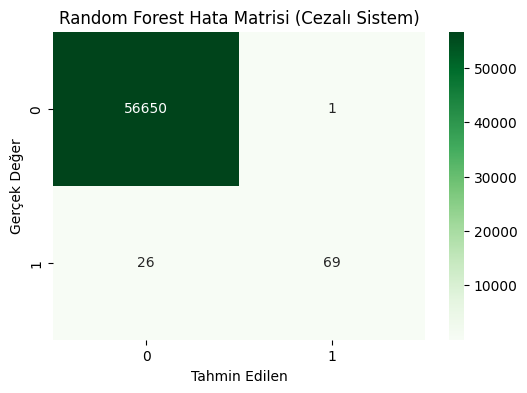

In [30]:
print("--- MODEL 3: RANDOM FOREST (CEZALI) ---")

# n_estimators=100 (100 tane ağaç kuruyo) ve class_weight='balanced' (cezayı hepsine uyguluyoruz)
# n_jobs=-1 ile Kaggle'daki tüm işlemci gücünü kullanmasını sağlıyoruz .
model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)

# Model ders çalışıyor 
print("Random Forest eğitiliyor, lütfen bekleyin")
model_rf.fit(X_train, y_train)

# Sınav Yapıyor
y_pred_rf = model_rf.predict(X_test)
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]

# -- - SONUÇLAR   --
print("\n Random Forest Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f" Random Fore st ROC-AUC Skoru: {roc_auc_rf:.4f}\n")

# Hata Matrisi 
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Hata Matrisi (Cezalı Sistem)')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen')
plt.show()

Matrisi incelediğimizde 26 dolandırıcılık (fraud) ile diğer sonuçlara göre daha düşük bir başarı oranına sahip olduğunu görüyoruz Random Forest'in. Lakin diğerleri ile kıyaslandığında neredeyse hiçbir güvenilir müşteriye güvenlik amacı ile dolandırıcı damgasını vurmuyor ve geri bildirim yapmıyoruz.

- MODEL 5: KARAR AĞACI (Decision Tree) (CEZALI) ---
Karar Ağacı eğitiliyor

 Karar Ağacı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56651
           1       0.04      0.85      0.07        95

    accuracy                           0.96     56746
   macro avg       0.52      0.91      0.53     56746
weighted avg       1.00      0.96      0.98     56746

 Karar Ağacı ROC-AUC Skoru: 0.9061



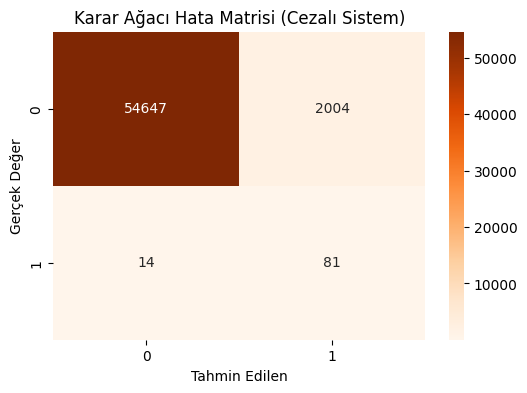

In [31]:
print("- MODEL 5: KARAR AĞACI (Decision Tree) (CEZALI) ---")

# class_weight='balanced' ile ceza sistemini aktif ediyoruz.
# max_depth=5 ile ağacın veriyi ezberlemesini (overfitting) önlüyoruz.
model_dt = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

# Model ders çalışıyor
print("Karar Ağacı eğitiliyor")
model_dt.fit(X_train, y_train)

# Sınav yapılıyor
y_pred_dt = model_dt.predict(X_test)
y_prob_dt = model_dt.predict_proba(X_test)[:, 1]

# --- SONUÇLAR -*-
print("\n Karar Ağacı Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_dt))

roc_auc_dt = roc_auc_score(y_test, y_prob_dt)
print(f" Karar Ağacı ROC-AUC Skoru: {roc_auc_dt:.4f}\n")

# Hata Matrisi 
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges')
plt.title('Karar Ağacı Hata Matrisi (Cezalı Sistem)')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen')
plt.show()

Bu matrisde de hehr ne kadar dolandırıcı yakalama oranımız çok yüksekte olsa bir çok güveilir müşteriye dolandırıclık (fraud) şüphesi ile geri bildirim yapıldı.

---  BÜYÜK FİNAL: HANGİSİ KAZANDI? ---
 Lojistik Regresyon eğitiliyor ve sınava giriyor...
 Karar Ağacı eğitiliyor ve sınava giriyor...
 KNN eğitiliyor ve sınava giriyor...
 Naive Bayes eğitiliyor ve sınava giriyor...
 Random Forest eğitiliyor ve sınava giriyor...


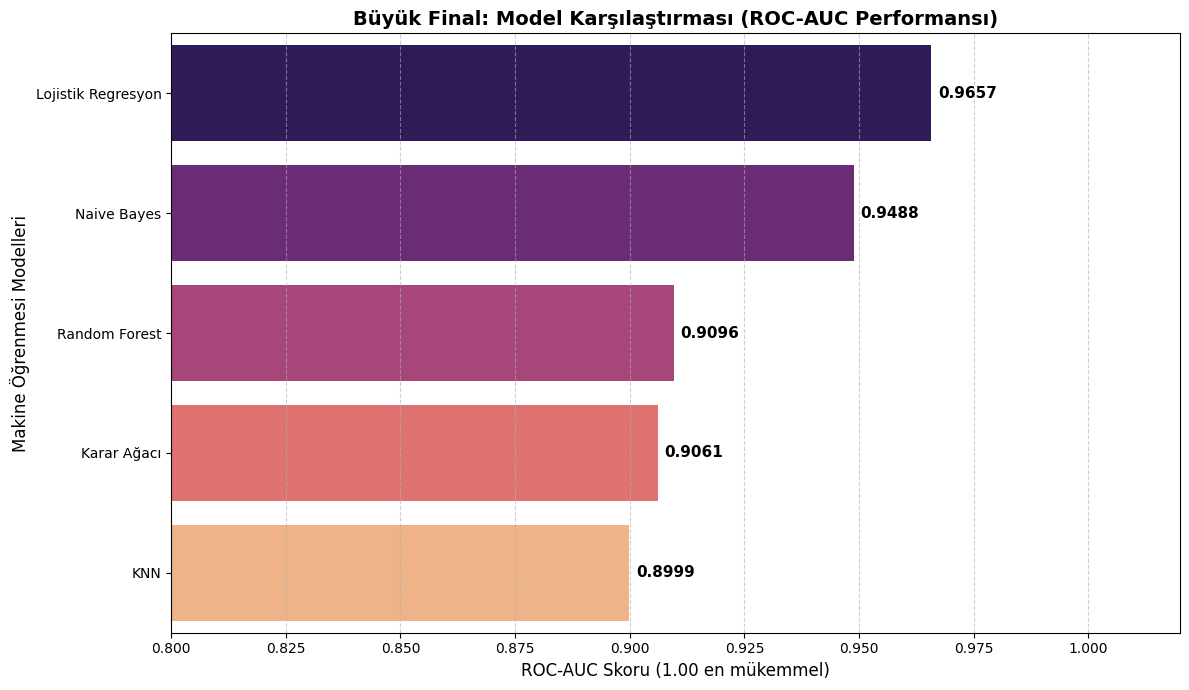

In [33]:
print("---  BÜYÜK FİNAL: HANGİSİ KAZANDI? ---")

# Tüm modelleri ve ceza sistemlerini listeye ekliyoruz
modeller = [
    ("Lojistik Regresyon", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    ("Karar Ağacı", DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)), 
    ("KNN", KNeighborsClassifier(n_neighbors=5)), # Ceza sistemini entegre edemedim
    ("Naive Bayes", GaussianNB()), # Ceza sistemini entegre edemediğim diğer sistem
    ("Random Forest", RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1))
]

sonuclar = []

# Modeller sırayla sınava giriyor
for isim, model in modeller:
    print(f" {isim} eğitiliyor ve sınava giriyor...")
    model.fit(X_train, y_train)
    
    # Accuracy (Doğruluk) tuzağına düşmemek için ROC-AUC skorunu hesaplıyoruz
    y_prob = model.predict_proba(X_test)[:, 1]
    puan = roc_auc_score(y_test, y_prob)
    
    sonuclar.append({"Model": isim, "ROC-AUC Skoru": puan})

# --- GRAFİK ÇİZİMİ ---
# Sonuçları yüksek puandan düşüğe doğru sıralayalım
sonuc_df = pd.DataFrame(sonuclar).sort_values(by="ROC-AUC Skoru", ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x="ROC-AUC Skoru", y="Model", hue="Model", data=sonuc_df, palette="magma", legend=False)

# Barların sonuna skorları yazdıralım
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=5, fontweight='bold', fontsize=11)

plt.title('Büyük Final: Model Karşılaştırması (ROC-AUC Performansı)', fontsize=14, fontweight='bold')
plt.xlim(0.80, 1.02) # Grafiğin x eksenini daha net farklar görünsün diye 0.80'den başlattık
plt.xlabel('ROC-AUC Skoru (1.00 en mükemmel)', fontsize=12)
plt.ylabel('Makine Öğrenmesi Modelleri', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Kredi kartı sahtekarlığı gibi aşırı dengesiz veri setlerinde yürütülen bu projede, sentetik veri üretmek yerine orijinal veri yapısını koruyan "Sınıf Ağırlıklandırma" (Ceza Sistemi) stratejisi kullanılmış ve modellerin ROC-AUC performansları kıyaslanmıştır. Sonuçlara göre, ceza sistemini matematiksel olarak en iyi optimize eden Lojistik Regresyon (0.9657 ROC-AUC), gerçek dolandırıcıları yakalamada (Recall) zirveye oturarak bankalar için en güvenilir finansal kalkan olduğunu kanıtlamıştır. Öte yandan, Random Forest (0.9096 ROC-AUC) masum müşterilere neredeyse hiç yanlış alarm vermeyerek kusursuz bir müşteri deneyimi potansiyeli sunarken; bu ceza mantığını desteklemeyen KNN (0.8999) ve Naive Bayes (0.9488) gibi algoritmalar hedefin gerisinde kalmıştır. Özetle bu çalışma, makine öğrenmesinde 'en iyi modelin' salt genel doğruluk (accuracy) oranıyla değil; bankanın "maksimum finansal güvenlik" ile "sıfır müşteri şikayeti" (Tip 1 ve Tip 2 Hata Trade-off'u) arasındaki risk tercihine göre belirlenmesi gerektiğini bilimsel olarak ortaya koymaktadır.